## Experiments - May 19, 2022


Hyperparam choices:

Criterion = CrossEntropyLoss  
Optimizer = SGD
num_epochs = 300  
Random split generator seeded: 73    
batch_size = 10

- TODO - stop when val stops improving  


### [Global Image](#1.1)
1. unweighted 
    - 1.1 [Base CNN - scaled down to 28x28](#1.1)
    - 1.2 [ResNet - scaled down to 212x212](#1.2)

2. weighted sample
    - 2.1 [Base CNN - scaled  down to 28x28](#2.1)
    - 2.2 [ResNet - scaled down to 212x212](#2.2)

### [Local ROI](#3.1)
3. unweighted
    - 3.1 [Base CNN - cropped 28x28 roi](#3.1)
    - 3.2 [ResNet - roi interpolated/scaled up to 212x212](#3.2)

4. weighted sampling
    - 4.1 [Base CNN - cropped 28x28 roi](#4.1)
    - 4.2 [ResNet - roi interpolated/scaled up to 212x212](#4.2)


Experiments TBD - cnn-lstm. factors are weighted sampling +/-, sequence length like 1-50, can swap in resnet or pretrain some.




In [1]:
import os
import torch
from cnn_driver import train, test, get_dataloaders
from parsing_utils import make_parser
from models import BaseCNN, VGG_Model, ResNet18, ResBlock

from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss
import pickle
import matplotlib.pyplot as plt

/home/rachel/anaconda3/envs/ornet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SyntaxError: invalid syntax (cnn_driver.py, line 352)

In [ ]:
# So go to driver
    # get all the vall losses
    # find index of the lowest one
    #save state of model at that epoch.

In [2]:

def plot_losses(model_name):
    # name = model_name.split(".")[0] + "pkl"
    name = "l2.pkl"
    path = os.path.join("/home/rachel/ornet/losses/", name)

    with open(path, 'rb') as f:
        d = pickle.load(f)
        
    t = d["train_loss"]
    v = d["val_loss"]
    plt.plot(t,'-o')
    plt.plot(v,'-o')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Train','Valid'])
    plt.title('Train vs Valid Accuracy')

In [3]:
class JupyterArgs:
    def __init__(self):
        self.batch_size = 10
        self.roi = False
        self.weighted_samples = False
        self.cuda = -1
        self.lr = 1e-3
        self.epochs = 300
        self.classes= ['control', 'mdivi', 'llo']
        self.input_dir = "/data/ornet/single_cells_cnns"
        # self.save = True
        self.save_dir = "/home/rachel/ornet/models/"
        self.save_as = "model1.pth"
        self.train = True
        # self.get_features = "/home/rachel/ornet/representations/"
        self.get_features = False
        self.get_losses = "/home/rachel/ornet/losses/"


args = JupyterArgs()

In [4]:
"""
we have more segmented cell videos saved on logan then intermediates.
best to rerun ornet on raw data, but till discrepancy is resolved this
will result in using the 114 samples that Neelima used in the last scipy submit
class balance 29, 31, 54
"""
path_to_intermediates = "/data/ornet/gmm_intermediates"
accept_list = []
for subdir in args.classes:
    path = os.path.join(path_to_intermediates, subdir)
    for file in os.listdir(path):
        if 'normalized' in file:
            accept_list.append(file.split(".")[0])

device = 'cpu' if not torch.cuda.is_available() else 'cuda'
device = torch.device(device)


### Global image

<a id='1.1'></a>
1.1

Using global image inputs
/data/ornet/single_cells_cnns
Testing
Accuracy: tensor(0.4167, device='cuda:0')
['control', 'mdivi', 'llo']
[[0 1 1]
 [0 0 2]
 [3 0 5]]


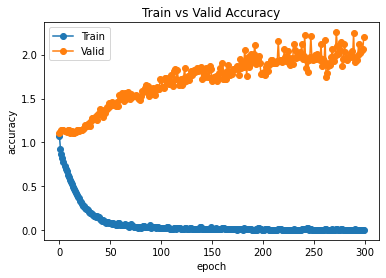

In [34]:
# 1.1
args.save_as = "test.pth"
# args.save_as = "global_BaseCNN_unweighted_05-19.pth"
args.roi=False
args.weighted_samples = False
args.epochs = 300

train_dataloader, test_dataloader, val_dataloader = get_dataloaders(
    args, accept_list, resize=28)

# model = BaseCNN()
model = ResNet18(in_channels=2, resblock=ResBlock, outputs=3)
model.to(device)

if args.train:
    print("Training")
    train(args, model, train_dataloader, val_dataloader, device=device)

plot_losses(args.save_as)

saved_state = torch.load(os.path.join(args.save_dir, args.save_as))
model.load_state_dict(saved_state)
print("Testing")
test(args, model, test_dataloader, device=device)


<a id='1.2'></a>
1.2

In [8]:
# 1.2
args.save_as = "global_ResNet_unweighted_05-18.pth"
args.roi=False
args.weighted_samples = False

train_dataloader, test_dataloader, val_dataloader = get_dataloaders(
    args, accept_list, resize=224)

# model = BaseCNN()
model = ResNet18(in_channels=2, resblock=ResBlock, outputs=3)
model.to(device)

if args.train:
    print("Training")
    train(args, model, train_dataloader, val_dataloader, device=device)

saved_state = torch.load(os.path.join(args.save_dir, args.save_as))
model.load_state_dict(saved_state)
print("Testing")
test(args, model, test_dataloader, device=device)

Using global image inputs
/data/ornet/single_cells_cnns
91
91
Testing
Accuracy: tensor(0.5000, device='cuda:0')
['control', 'mdivi', 'llo']
[[0 1 1]
 [0 2 0]
 [4 0 4]]


<a id='2.1'></a>
2.1

In [9]:
# 2.1
args.save_as = "global_BaseCNN_weighted_05-18.pth"
args.weighted_samples = True

train_dataloader, test_dataloader, val_dataloader = get_dataloaders(
    args, accept_list, resize=28)

model = BaseCNN()
# model = ResNet18(in_channels=2, resblock=ResBlock, outputs=3)
model.to(device)

if args.train:
    print("Training")
    train(args, model, train_dataloader, val_dataloader, device=device)

saved_state = torch.load(os.path.join(args.save_dir, args.save_as))
model.load_state_dict(saved_state)
print("Testing")
test(args, model, test_dataloader, device=device)

Using global image inputs
/data/ornet/single_cells_cnns
91
91
using weighted sampling
Testing
Accuracy: tensor(0.3333, device='cuda:0')
['control', 'mdivi', 'llo']
[[0 2 0]
 [1 1 0]
 [4 1 3]]


<a id='2.2'></a>
2.2

In [10]:
# 2.2
args.save_as = "global_ResNet_weighted_05-18.pth"
args.weighted_samples = True

train_dataloader, test_dataloader, val_dataloader = get_dataloaders(
    args, accept_list, resize=224)

# model = BaseCNN()
model = ResNet18(in_channels=2, resblock=ResBlock, outputs=3)
model.to(device)


if args.train:
    print("Training")
    train(args, model, train_dataloader, val_dataloader, device=device)

saved_state = torch.load(os.path.join(args.save_dir, args.save_as))
model.load_state_dict(saved_state)
print("Testing")
test(args, model, test_dataloader, device=device)

Using global image inputs
/data/ornet/single_cells_cnns
91
91
using weighted sampling
Testing
Accuracy: tensor(0.3333, device='cuda:0')
['control', 'mdivi', 'llo']
[[1 1 0]
 [2 0 0]
 [5 0 3]]


########

In [13]:
args.train = False

### ROI Image
<a id='3.1'></a>
3.1

In [14]:
# 3.1
args.save_as = "roi_BaseCNN_unweighted_05-18.pth"
saved_models.append(args.save_as)
args.roi = True
args.weighted_samples = False

train_dataloader, test_dataloader, val_dataloader = get_dataloaders(
    args, accept_list, resize=28)

model = BaseCNN()
# model = ResNet18(in_channels=2, resblock=ResBlock, outputs=3)
model.to(device)

if args.train:
    print("Training")
    train(args, model, train_dataloader, val_dataloader, device=device)

saved_state = torch.load(os.path.join(args.save_dir, args.save_as))
model.load_state_dict(saved_state)
print("Testing")
test(args, model, test_dataloader, device=device)

Using ROI inputs
/data/ornet/single_cells_cnns
91
91
Testing
Accuracy: tensor(0.5833, device='cuda:0')
['control', 'mdivi', 'llo']
[[1 1 0]
 [1 0 1]
 [1 1 6]]


<a id='3.2'></a>
3.2

In [15]:
# 3.2
args.save_as = "roi_ResNet_unweighted_05-18.pth"
saved_models.append(args.save_as)
args.roi = True
args.weighted_samples = False

train_dataloader, test_dataloader, val_dataloader = get_dataloaders(
    args, accept_list, resize=224)

# model = BaseCNN()
model = ResNet18(in_channels=2, resblock=ResBlock, outputs=3)
model.to(device)

if args.train:
    print("Training")
    train(args, model, train_dataloader, val_dataloader, device=device)

saved_state = torch.load(os.path.join(args.save_dir, args.save_as))
model.load_state_dict(saved_state)
print("Testing")
test(args, model, test_dataloader, device=device)


Using ROI inputs
/data/ornet/single_cells_cnns
91
91
Testing
Accuracy: tensor(0.5833, device='cuda:0')
['control', 'mdivi', 'llo']
[[1 0 1]
 [1 0 1]
 [2 0 6]]


<a id='4.1'></a>
4.1

In [16]:
# 4.1
args.save_as = "roi_BaseCNN_weighted_05-18.pth"
saved_models.append(args.save_as)
args.roi = True
args.weighted_samples = True


train_dataloader, test_dataloader, val_dataloader = get_dataloaders(
    args, accept_list, resize=28)

model = BaseCNN()
# model = ResNet18(in_channels=2, resblock=ResBlock, outputs=3)
model.to(device)

if args.train:
    print("Training")
    train(args, model, train_dataloader, val_dataloader, device=device)

saved_state = torch.load(os.path.join(args.save_dir, args.save_as))
model.load_state_dict(saved_state)
print("Testing")
test(args, model, test_dataloader, device=device)

Using ROI inputs
/data/ornet/single_cells_cnns
91
91
using weighted sampling
Testing
Accuracy: tensor(0.7500, device='cuda:0')
['control', 'mdivi', 'llo']
[[2 0 0]
 [0 2 0]
 [0 3 5]]


<a id='4.2'></a>
4.2

In [17]:
# 4.2
args.save_as = "roi_ResNet_weighted_05-18.pth"
saved_models.append(args.save_as)
args.roi = True
args.weighted_samples = True

train_dataloader, test_dataloader, val_dataloader = get_dataloaders(
    args, accept_list, resize=224)

# model = BaseCNN()
model = ResNet18(in_channels=2, resblock=ResBlock, outputs=3)
model.to(device)


if args.train:
    print("Training")
    train(args, model, train_dataloader, val_dataloader, device=device)

saved_state = torch.load(os.path.join(args.save_dir, args.save_as))
model.load_state_dict(saved_state)
print("Testing")
test(args, model, test_dataloader, device=device)

Using ROI inputs
/data/ornet/single_cells_cnns
91
91
using weighted sampling
Testing
Accuracy: tensor(0.5000, device='cuda:0')
['control', 'mdivi', 'llo']
[[2 0 0]
 [1 1 0]
 [4 1 3]]
